# Установка зависимостей

In [2]:
CUDA_CORE=1
MODEL_USED="facebook/nllb-200-distilled-600M"
# MODEL_USED="facebook/nllb-200-1.3B"
LANGUAGE_ORIGIN_LABEL="nivkh_Cyrl"
LANGUAGE_TARGET_LABEL="rus_Cyrl"
LANGUAGE_SIMILAR_LABEL="bak_Cyrl"
LANGUAGE_FILE_ORIGIN_LABEL="nivkh"
LANGUAGE_FILE_TARGET_LABEL="rus"
NORMALIZER_LANGUAGE="ru"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
MODEL_SAVE_PATH="/content/drive/MyDrive/models/nllb_nivkh_rus_600M_sakh_extended"
!mkdir -p {MODEL_SAVE_PATH}

In [5]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [6]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.33.0 which is incompatible.


In [7]:
!pip install ipywidgets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00


In [8]:
!pip install scikit-learn -q
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import seaborn as sns
from IPython.display import clear_output
from IPython.utils import io
import torch
import time
from torch import optim
from torch.nn import functional as F
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer
import shutil
import pickle
import os
import re
import json

# Обработка данных

In [10]:
data = []


input_dir = '/content/drive/MyDrive/translation_resplit3'
srcs = [
    '_agm', '_shklg', '_shtrn', '_sng', '_grz',
    'a158_bible', 'a159_bible', 'a160_bible',
    'a161_bible', 'a162_bible', 'a163_bible', 'a164_bible'
]
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith('.txt') and any(src in filename for src in srcs):
        full_path = os.path.join(input_dir, filename)
        tag_match = re.search(r'_(\w+)\.txt$', filename)
        tag = tag_match.group(1) if tag_match else None
        with open(full_path, 'r', encoding='utf-8') as f:
            src, tgt = None, None
            for line in f:
                if re.match(r'^\d+>', line):
                    src = re.sub(r'^\d+>\s*', '', line).strip()
                elif re.match(r'^\d+=', line):
                    tgt = re.sub(r'^\d+=\s*', '', line).strip()
                    if src is not None:
                        data.append({
                            'nivkh': src,
                            'rus': tgt,
                            'file': filename,
                            'source': tag
                        })
                        src, tgt = None, None
print(len(data))

  0%|          | 0/99 [00:00<?, ?it/s]

7404


In [11]:
with open('/content/drive/MyDrive/FilteredNivkhTxt/valid.json') as json_file:
    valid_files = json.load(json_file)

srcs = [
    '_agm', '_shklg', '_shtrn', '_sng', '_grz',
    'a158_bible', 'a159_bible', 'a160_bible',
    'a161_bible', 'a162_bible', 'a163_bible', 'a164_bible'
]
for filename in tqdm(valid_files):
    if filename.endswith('.txt') and any(src in filename for src in srcs):
        full_path = os.path.join(input_dir, filename)
        tag_match = re.search(r'_(\w+)/n_r_p.txt$', filename)
        tag = tag_match.group(1) if tag_match else None
        with open(full_path, 'r', encoding='utf-8') as f:
            src, tgt = None, None
            for line in f:
                if re.match(r'^\d+>', line):
                    src = re.sub(r'^\d+>\s*', '', line).strip()
                elif re.match(r'^\d+=', line):
                    tgt = re.sub(r'^\d+=\s*', '', line).strip()
                    if src is not None:
                        data.append({
                            'nivkh': src,
                            'rus': tgt,
                            'file': filename,
                            'source': tag
                        })
                        src, tgt = None, None
print(len(data))

  0%|          | 0/253 [00:00<?, ?it/s]

7659


In [12]:
df = pd.DataFrame(data)
df

,nivkh,rus,file,source
0,Ниӻывыӈ неныӈ иехылуӈ мен быр̌к ӿунывхарт.,Гиляк один его мальчик вдвоем только жили.,a141_shtrn.txt,shtrn
1,Ӿунывыфке йер̌ чо наныгыр̌ вир̌ вифке.,"долго жили, его отец рыбу ловить пошел, далеко...",a141_shtrn.txt,shtrn
2,"Лахи нан ихур̌ шор̌-теӻар̌, чхар̌ тар̌ шувыр̌,...","Кэту одну убив, принес, дров нарубив, развел, ...",a141_shtrn.txt,shtrn
3,"Чай вир̌ ӄ’ан-чо ихур̌ шор̌-теӻар̌, чхар̌ тарa...","Снова пошел, кунжу убив, принес, дров на- руби...",a141_shtrn.txt,shtrn
4,"Ӿунхе пхыр̌ ехыр̌ пшыр̌, пехлыӈтох: Олa.","Оттуда вернувшись, обратно пришел, своему маль...",a141_shtrn.txt,shtrn
...,...,...,...,...
7654,"""Ни ғылута ӄ'ауны, мығн чиӈрла мра чи нытра, ч...","""Твое наказание тяжелее, чем я смогу вынести. ...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7655,"Ни Мивух пай ныӈӻа, нуғир̌ ньворк ниғныто яӻло...","Я буду скитаться по земле, и первый же встречн...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7656,"""Ӄ'аук, - Курӈ маӈӷла Ызык итт, - нарлу чи хуӻ...","""Нет, - сказал Бог, - тому, кто убьет тебя, Я ...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7657,"Накр Курӈ маӈӷла Ызык, нар ӿакир̌к ёрр̌ и хута...","И Бог сделал Каину особый знак, чтобы никто, к...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible


In [13]:
df['nivkh_norm'] = df['nivkh'].str.lower().str.strip()
df['rus_norm'] = df['rus'].str.lower().str.strip()
df = df.drop_duplicates(subset=['nivkh_norm', 'rus_norm']).drop(columns=['nivkh_norm', 'rus_norm']).reset_index(drop=True)
df

,nivkh,rus,file,source
0,Ниӻывыӈ неныӈ иехылуӈ мен быр̌к ӿунывхарт.,Гиляк один его мальчик вдвоем только жили.,a141_shtrn.txt,shtrn
1,Ӿунывыфке йер̌ чо наныгыр̌ вир̌ вифке.,"долго жили, его отец рыбу ловить пошел, далеко...",a141_shtrn.txt,shtrn
2,"Лахи нан ихур̌ шор̌-теӻар̌, чхар̌ тар̌ шувыр̌,...","Кэту одну убив, принес, дров нарубив, развел, ...",a141_shtrn.txt,shtrn
3,"Чай вир̌ ӄ’ан-чо ихур̌ шор̌-теӻар̌, чхар̌ тарa...","Снова пошел, кунжу убив, принес, дров на- руби...",a141_shtrn.txt,shtrn
4,"Ӿунхе пхыр̌ ехыр̌ пшыр̌, пехлыӈтох: Олa.","Оттуда вернувшись, обратно пришел, своему маль...",a141_shtrn.txt,shtrn
...,...,...,...,...
7190,"""Ни ғылута ӄ'ауны, мығн чиӈрла мра чи нытра, ч...","""Твое наказание тяжелее, чем я смогу вынести. ...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7191,"Ни Мивух пай ныӈӻа, нуғир̌ ньворк ниғныто яӻло...","Я буду скитаться по земле, и первый же встречн...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7192,"""Ӄ'аук, - Курӈ маӈӷла Ызык итт, - нарлу чи хуӻ...","""Нет, - сказал Бог, - тому, кто убьет тебя, Я ...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7193,"Накр Курӈ маӈӷла Ызык, нар ӿакир̌к ёрр̌ и хута...","И Бог сделал Каину особый знак, чтобы никто, к...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible


In [14]:
def restore_nivkh_capitalization(sents):
    capitalized_sents = []
    char_map = {
    'ӄ': 'Ӄ',
    'ӈ': 'Ӈ',
    'ӽ': 'Ӽ',
    'ғ': 'Ғ',
    'ҳ': 'Ҳ',
    'χ': 'Χ',
    'ӻ': 'Ӻ',
    'р̌': 'Р̌',
    'ӿ': 'Ӿ',
    'ў': 'Ў'
}
    for sent in sents:
        if not sent:
            capitalized_sents.append(sent)
            continue
        first_char = sent[0]
        rest_of_sent = sent[1:]
        if first_char in char_map.keys():
            capitalized_first = char_map[first_char]
        else:
            capitalized_first = first_char.upper()
        capitalized_sent = capitalized_first + rest_of_sent
        capitalized_sents.append(capitalized_sent)
    return capitalized_sents

In [15]:
df['nivkh'] = restore_nivkh_capitalization(df['nivkh'])
df

,nivkh,rus,file,source
0,Ниӻывыӈ неныӈ иехылуӈ мен быр̌к ӿунывхарт.,Гиляк один его мальчик вдвоем только жили.,a141_shtrn.txt,shtrn
1,Ӿунывыфке йер̌ чо наныгыр̌ вир̌ вифке.,"долго жили, его отец рыбу ловить пошел, далеко...",a141_shtrn.txt,shtrn
2,"Лахи нан ихур̌ шор̌-теӻар̌, чхар̌ тар̌ шувыр̌,...","Кэту одну убив, принес, дров нарубив, развел, ...",a141_shtrn.txt,shtrn
3,"Чай вир̌ ӄ’ан-чо ихур̌ шор̌-теӻар̌, чхар̌ тарa...","Снова пошел, кунжу убив, принес, дров на- руби...",a141_shtrn.txt,shtrn
4,"Ӿунхе пхыр̌ ехыр̌ пшыр̌, пехлыӈтох: Олa.","Оттуда вернувшись, обратно пришел, своему маль...",a141_shtrn.txt,shtrn
...,...,...,...,...
7190,"""Ни ғылута ӄ'ауны, мығн чиӈрла мра чи нытра, ч...","""Твое наказание тяжелее, чем я смогу вынести. ...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7191,"Ни Мивух пай ныӈӻа, нуғир̌ ньворк ниғныто яӻло...","Я буду скитаться по земле, и первый же встречн...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7192,"""Ӄ'аук, - Курӈ маӈӷла Ызык итт, - нарлу чи хуӻ...","""Нет, - сказал Бог, - тому, кто убьет тебя, Я ...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7193,"Накр Курӈ маӈӷла Ызык, нар ӿакир̌к ёрр̌ и хута...","И Бог сделал Каину особый знак, чтобы никто, к...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible


In [16]:
ENGLISH_WORDS = re.compile(r'\b[a-zA-Z]+\b')
URLS = re.compile(r'https?://\S+|www\.\S+')
EMAILS = re.compile(r'\S+@\S+')
PHONES = re.compile(r'(\+?\d[\d\s\-()]{6,})')
BRACKETS = re.compile(r'\[[^\]]*\]|\([^\)]*\)')
JUNK = re.compile(r'[~*^%$@#_=<>\\|]')

def clean_text(text):
    text = URLS.sub('', text)
    text = EMAILS.sub('', text)
    text = PHONES.sub('', text)
    text = BRACKETS.sub('', text)
    text = ENGLISH_WORDS.sub('', text)
    text = JUNK.sub('', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [17]:
def clean_up(sents):
    map = {
        'ь:': 'ь.', 'Ē~ӽ': 'Ех', 'ѵ': 'у', 'Ē': 'Е', 'ā': 'а', 'ñ': '', '×': 'у',
        'ī': 'и', 'Ō': 'О', 'ō': 'о', 'р̃': 'р̌', 'р̆': 'р̌', '~': '-',
        '§.': '', 'ÿ': 'у', 'ʻ': '', 'ʼ': "'", 'р˘': 'р̌', 'р̀': 'р̌',
        '́': '', '̃': '', '̄': '', '̉': '', '̍': '', '̔': 'р', '̣': '',
        '̥': '', '̨': '', '̬': '', '̓': '', 'џ': 'ц', 'ґ': 'г', 'Ҥ': 'Ӈ',
        'Ң': 'Ӈ', 'ң': 'ӈ', 'Ӊ': 'Ӈ', 'ӊ': 'ӈ', 'ҧ': 'п', 'Ұ': 'ӻ',
        'ӗ': 'е', 'Өа х': 'Х', 'ӯ': 'у', 'ӱ': 'у', 'ӧ': 'ё', 'ҳ': 'х',
        '՚': "'", 'ḗ': 'е', 'ṓ': 'о', 'ṕ': 'р̌', '‑': '-', '‐': '-',
        '–': '-', '—': '-', '‘': "'", '’': "'", '“': '"', '”': '"',
        '«': '"', '»': '"', '•': '', '…': '...', '▸': '', 'Р̆': 'Р̌',
        'ē': 'е', 'Ӿ ': '! ', 'Ӿ" ': '!" ', "\\'": "'"
    }
    cleaned_sents = []
    for sent in sents:
        for old, new in map.items():
            sent = sent.replace(old, new)
            sent = clean_text(sent)
        cleaned_sents.append(sent.replace("\\", ""))
    return cleaned_sents

In [18]:
df['nivkh'] = clean_up(df['nivkh'])
df['rus'] = clean_up(df['rus'])
df

,nivkh,rus,file,source
0,Ниӻывыӈ неныӈ иехылуӈ мен быр̌к ӿунывхарт.,Гиляк один его мальчик вдвоем только жили.,a141_shtrn.txt,shtrn
1,Ӿунывыфке йер̌ чо наныгыр̌ вир̌ вифке.,"долго жили, его отец рыбу ловить пошел, далеко...",a141_shtrn.txt,shtrn
2,"Лахи нан ихур̌ шор̌-теӻар̌, чхар̌ тар̌ шувыр̌,...","Кэту одну убив, принес, дров нарубив, развел, ...",a141_shtrn.txt,shtrn
3,"Чай вир̌ ӄ'ан-чо ихур̌ шор̌-теӻар̌, чхар̌ тарa...","Снова пошел, кунжу убив, принес, дров на- руби...",a141_shtrn.txt,shtrn
4,"Ӿунхе пхыр̌ ехыр̌ пшыр̌, пехлыӈтох: Олa.","Оттуда вернувшись, обратно пришел, своему маль...",a141_shtrn.txt,shtrn
...,...,...,...,...
7190,"""Ни ғылута ӄ'ауны, мығн чиӈрла мра чи нытра, ч...","""Твое наказание тяжелее, чем я смогу вынести. ...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7191,"Ни Мивух пай ныӈӻа, нуғир̌ ньворк ниғныто яӻло...","Я буду скитаться по земле, и первый же встречн...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7192,"""Ӄ'аук, - Курӈ маӈӷла Ызык итт, - нарлу чи хуӻ...","""Нет, - сказал Бог, - тому, кто убьет тебя, Я ...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible
7193,"Накр Курӈ маӈӷла Ызык, нар ӿакир̌к ёрр̌ и хута...","И Бог сделал Каину особый знак, чтобы никто, к...",/content/drive/MyDrive/FilteredNivkhTxt/a158_b...,bible


In [19]:
df['source'] = df['source'].str.replace('srhsh', 'shrsh', regex=False)

In [20]:
sources = list(set(df['source']))
sources

['shklg', 'shtrn', 'sng', 'bible', 'agm', 'grz']

In [21]:
df_train, df_devtest = train_test_split(df, test_size=0.2, random_state=42, stratify=df['source'])
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42, stratify=df_devtest['source'])

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5756 entries, 6482 to 4152
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   5756 non-null   object
 1   rus     5756 non-null   object
 2   file    5756 non-null   object
 3   source  5756 non-null   object
dtypes: object(4)
memory usage: 224.8+ KB


In [23]:
df_train.head()

,nivkh,rus,file,source
6482,"П' муспи ӿытыроӽа вира,","На середину своего муспи приехав,",a462_sng.txt,sng
5558,"Мен ӈафӄ наф п' уньр̌к хур̌ ғутюра,","Наш товарищ, теперь своего уньршка убив, сбросил,",a462_sng.txt,sng
7010,Хумтиӈ тылгуш пуру...?,Что это было?,/content/drive/MyDrive/FilteredNivkhTxt/06_agm...,agm
3038,Итнд:,сказал:,a462_sng.txt,sng
1128,Ытыта.,"ой, ой, ой.",a133_shtrn.txt,shtrn


In [24]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 719 entries, 6090 to 1133
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   719 non-null    object
 1   rus     719 non-null    object
 2   file    719 non-null    object
 3   source  719 non-null    object
dtypes: object(4)
memory usage: 28.1+ KB


In [25]:
df_dev.head()

,nivkh,rus,file,source
6090,"Кыпрӻарра,","Стоя стоит,",a462_sng.txt,sng
4700,Пасӄроӽ ӽороӈа -,В другую сторону наклонил -,a462_sng.txt,sng
2215,Ниӻывыӈ зат ихундрa.,"Люди колотили, убили его.",a136_shtrn.txt,shtrn
1488,"Мыз-ниӻывыӈ ӄ'ах герa, пунд герa кузир̌-вир̌.","Наш Гиляк копье взяв, лук взяв отправился.",a138_shtrn.txt,shtrn
3963,"Ӿуӈ гер̌ӄ раӈфтиӈ ӈаньғыф,","В этом море все кости,",a462_sng.txt,sng


In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 1167 to 561
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   720 non-null    object
 1   rus     720 non-null    object
 2   file    720 non-null    object
 3   source  720 non-null    object
dtypes: object(4)
memory usage: 28.1+ KB


In [27]:
df_test.head()

,nivkh,rus,file,source
1167,"Асхa, йаӈр̌ ӄ'онд-нa.","О брат, чего ты спишь.",a133_shtrn.txt,shtrn
6438,П' эрӽ итнд.,Сам себе сказал.,a462_sng.txt,sng
7087,Нуд ӿабы сик Хлуди ӄаврд.,"Они Поднимают невод С рыбой, Холодной, Тяжелой.",/content/drive/MyDrive/FilteredNivkhTxt/34_sng...,sng
2006,"Озир̌, йаф ахр̌ нух варарa, йаӈ намых ахр̌ кер...","Поднялся, его тоже иголкам подобны были, его в...",a134_shtrn.txt,shtrn
2377,Ронин тамх-танате.,Давай вместе табак курить.,a136_shtrn.txt,shtrn


# Настройка модели

## Настройка токенизатора

In [99]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [100]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [101]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [102]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [103]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,nivkh,nivkh_words,nivkh_toks,rus,rus_words,rus_toks
821,"Ӿалныр̌ зур̌, туур̌ йер̌ инит.","[Ӿалныр, ̌, зур, ̌, ,, туур, ̌, йер, ̌, инит, .]","[▁, Ӿ, ал, ныр, ̌, ▁зур, ̌, ,, ▁ту, ур, ̌, ▁й,...","Помост обмыла, мяса наварила, ели.","[Помост, обмыла, ,, мяса, наварила, ,, ели, .]","[▁Помо, ст, ▁об, мы, ла, ,, ▁мя, са, ▁на, вари..."
1573,Ӿуӈ ӄер̌ӽур̌ мағыр̌.,"[Ӿуӈ, ӄер, ̌, ӽур, ̌, мағыр, ̌, .]","[▁, Ӿ, у, ӈ, ▁, ӄ, ер, ̌, ӽ, ур, ̌, ▁ма, ғыр, ...",Эта удочка спустилась.,"[Эта, удочка, спустилась, .]","[▁Эта, ▁удо, чка, ▁с, пусти, лась, .]"
6385,"Херы хеми тура,","[Херы, хеми, тура, ,]","[▁Хер, ы, ▁хеми, ▁тура, ,]","И в верхнюю сторону, в сторону Головы Земли пр...","[И, в, верхнюю, сторону, ,, в, сторону, Головы...","[▁И, ▁в, ▁верх, нюю, ▁сторо, ну, ,, ▁в, ▁сторо..."
675,Нанӽ пос под.,"[Нанӽ, пос, под, .]","[▁Н, ан, ӽ, ▁пос, ▁под, .]",Старшая сестра ткань держит.,"[Старшая, сестра, ткань, держит, .]","[▁Стар, шая, ▁сестра, ▁т, кан, ь, ▁дер, жит, .]"
679,Нарара ӿухт п'отт.,"[Нарара, ӿухт, п, ', отт, .]","[▁Нара, ра, ▁, ӿ, у, хт, ▁п, ', от, т, .]",Кто халат шьет.,"[Кто, халат, шьет, .]","[▁Кто, ▁ха, лат, ▁ш, ь, ет, .]"


In [104]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

<ipython-input-104-8bf0a8236e3f>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,nivkh_toks,rus_toks,nivkh_words,rus_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,16.200100,11.347900,8.188100,7.263000
std,11.574863,7.710617,5.836294,4.841134
min,1.000000,2.000000,1.000000,1.000000
25%,9.000000,7.000000,5.000000,4.000000
50%,13.000000,9.000000,7.000000,6.000000
75%,19.000000,13.000000,10.000000,9.000000
max,144.000000,100.000000,68.000000,63.000000


In [105]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.9784931791258042
1.5624259947680021


In [106]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


In [107]:
texts_with_unk = [text for text in tqdm(df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/7195 [00:00<?, ?it/s]

19


In [108]:
import random
s = random.sample(texts_with_unk, 5)
s

['А хозяин дома на середине понаӻӈ .',
 'Ӿоландом наполнили!',
 'Место ӄангыл называемое под него,',
 'Ч ир монӻо!',
 "Т'лайвӈ ӿаӈӷр̌ называемое,"]

In [28]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [110]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/19 [00:00<?, ?it/s]

19


## Расширение словаря

In [111]:
from collections import Counter
all_texts = df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common()
    if v >= 3 and k not in ' '
])

  0%|          | 0/7195 [00:00<?, ?it/s]

In [112]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [113]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=6055,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

In [114]:
# !pip install protobuf==3.19.4 --force-reinstall

In [115]:
# !wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

In [116]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [117]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 263178
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 6973

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 260625
4420


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 260625. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


  0%|          | 0/4420 [00:00<?, ?it/s]

## Добавление тэга нового языка в токенизатор и модель

In [118]:
print('nivkh_Cyrl' in tokenizer.get_vocab())
print('rus_Cyrl' in tokenizer.get_vocab())

False
True


In [29]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_ORIGIN_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [120]:
fix_tokenizer(tokenizer)

In [121]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

260568 260442


In [122]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 260626. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(260626, 1024)

In [123]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# Обучение (A100)

## Предварительные шаги

In [30]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [31]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).to('cuda')
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
# model.to('cuda')

In [33]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [38]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 25000

In [35]:
import json

# losses = []
with open('/content/drive/MyDrive/models/nllb_nivkh_rus_600M_sakh_extended/losses.json') as json_file:
    losses = json.load(json_file)
losses[:5]

[8.30668830871582,
 9.350123405456543,
 8.247389793395996,
 9.937809944152832,
 8.829381942749023]

In [36]:
# losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [37]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['Яӈа вук ӈамх'], ['Его височный волос'], 'nivkh_Cyrl', 'rus_Cyrl')


## Циклы обучения (по тренировочным шагам)

In [ ]:
#@title 0-3k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/20000 [00:00<?, ?it/s]

0 8.30668830871582
1000 5.266247533082962
2000 2.8249690676927566
3000 2.1278356213569642


In [ ]:
#@title 3-6k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/16599 [00:00<?, ?it/s]

4000 1.7864461990594864
5000 1.6272827787995339
6000 1.316134775340557


In [37]:
#@title 6-19k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/13999 [00:00<?, ?it/s]

7000 1.3386002640724182
8000 1.1696798540353774
9000 0.9424383451938629
10000 0.7674622085988522
11000 0.608468980833888
12000 0.49861398151516917
13000 0.40393096271902323
14000 0.333621478676796
15000 0.2728377647474408
16000 0.22827669911831616
17000 0.19102997405454517
18000 0.15706032149493696
19000 0.13166424477100372


In [39]:
#@title 19-25k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/5000 [00:00<?, ?it/s]

20000 0.10861478657834232
21000 0.09727700750716031
22000 0.10249368536286056


KeyboardInterrupt: 

In [42]:
len(losses)

22525

<Axes: >

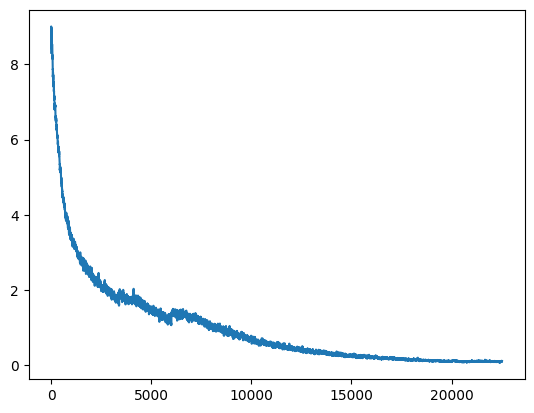

In [40]:
pd.Series(losses).ewm(10).mean().plot()

In [41]:
!ls -alsh $MODEL_SAVE_PATH

total 2.4G
431K -rw------- 1 root root 431K May 30 22:55 all_texts_file.csv
1.0K -rw------- 1 root root  927 May 31 01:36 config.json
 512 -rw------- 1 root root  184 May 31 01:36 generation_config.json
444K -rw------- 1 root root 444K May 31 01:39 losses.json
2.4G -rw------- 1 root root 2.4G May 31 01:36 pytorch_model.bin
4.8M -rw------- 1 root root 4.8M May 30 23:15 sentencepiece.bpe.model
3.5K -rw------- 1 root root 3.5K May 31 01:36 special_tokens_map.json
355K -rw------- 1 root root 355K May 30 22:55 spm_16k.model
128K -rw------- 1 root root 128K May 30 22:55 spm_16k.vocab
4.8M -rw------- 1 root root 4.8M May 30 22:55 spm_nllb_268k.model
1.0K -rw------- 1 root root  570 May 31 01:36 tokenizer_config.json


# Тестирование

In [43]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [44]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['Если жену искать направился, то, хорошенько мне сказав, меня заставь шаманить.']
['Анӻей наныгыр̌ виифхaй, урункр̌ нхерыр̌ нах лункйa.']
['Анӻей наныгыр̌ пшыхaй ургур̌ нхерйa, нах лункйa.']


In [45]:
t = "Ӿы нивх лу?"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

['Этот ли верах?']


In [46]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Этот ли верах?']

In [47]:
t = "Это правда!"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

["Махтур̌ п'уру!"]


In [48]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

["Махтур̌ п'уру!"]

In [49]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [50]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

In [51]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)

In [52]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 13.22 43.8/18.4/9.1/5.4 (BP = 0.940 ratio = 0.942 hyp_len = 3785 ref_len = 4019)
chrF2++ = 36.40
BLEU = 19.84 47.5/23.7/15.2/10.3 (BP = 0.970 ratio = 0.970 hyp_len = 4969 ref_len = 5121)
chrF2++ = 38.02


In [56]:
from collections import defaultdict

# метрики по источникам
scores = defaultdict(dict)
for src, df in df_test.groupby('source'):
    # rus --> nivkh
    refs_n2r = [df[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]
    preds_n2r = df[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist()
    scores[src]['bleu_RN'] = bleu_calc.corpus_score(preds_n2r, refs_n2r)
    scores[src]['chrf_RN'] = chrf_calc.corpus_score(preds_n2r, refs_n2r)
    # nivkh --> rus
    refs_r2n = [df[LANGUAGE_FILE_TARGET_LABEL].tolist()]
    preds_r2n = df[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist()
    scores[src]['bleu_NR'] = bleu_calc.corpus_score(preds_r2n, refs_r2n)
    scores[src]['chrf_NR'] = chrf_calc.corpus_score(preds_r2n, refs_r2n)

for src, s in scores.items():
    print(src)
    print('--------')
    for name, val in s.items():
        print(f'{name}: {val}')
    print()

agm
--------
bleu_RN: BLEU = 1.48 3.7/2.0/1.1/0.6 (BP = 1.000 ratio = 1.421 hyp_len = 27 ref_len = 19)
chrf_RN: chrF2++ = 8.48
bleu_NR: BLEU = 2.04 12.0/2.2/1.2/0.7 (BP = 0.961 ratio = 0.962 hyp_len = 25 ref_len = 26)
chrf_NR: chrF2++ = 10.45

bible
--------
bleu_RN: BLEU = 9.12 35.2/14.4/6.7/2.0 (BP = 1.000 ratio = 1.026 hyp_len = 196 ref_len = 191)
chrf_RN: chrF2++ = 24.02
bleu_NR: BLEU = 2.85 27.9/5.7/1.9/0.4 (BP = 0.886 ratio = 0.892 hyp_len = 190 ref_len = 213)
chrf_NR: chrF2++ = 15.49

grz
--------
bleu_RN: BLEU = 28.48 63.4/32.5/21.0/15.2 (BP = 1.000 ratio = 1.000 hyp_len = 153 ref_len = 153)
chrf_RN: chrF2++ = 43.20
bleu_NR: BLEU = 39.74 63.3/41.7/32.4/29.2 (BP = 1.000 ratio = 1.040 hyp_len = 180 ref_len = 173)
chrf_NR: chrF2++ = 54.16

shklg
--------
bleu_RN: BLEU = 2.27 35.3/3.6/2.3/1.6 (BP = 0.494 ratio = 0.586 hyp_len = 17 ref_len = 29)
chrf_RN: chrF2++ = 10.79
bleu_NR: BLEU = 5.99 29.2/9.5/2.8/1.7 (BP = 1.000 ratio = 1.000 hyp_len = 24 ref_len = 24)
chrf_NR: chrF2++ = 19.5

In [54]:
pd.options.display.max_colwidth = 100

In [55]:
df_test.sample(30, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,rus,nivkh,rus_translated,nivkh_translated
4922,Серая Гора с четырех вершинным хребтом ли.,Чавр вал ӈаски ныкрд пал ло.,На Серую Гору хребта горный порог ли,Чавр̌ ӈағр̌кис нуғ ӈаски хизӈ к'изра
3720,Мы жители - поселения в излуке Ығмифа.,Нина ығ-миф ӈалу вонгун.,Нашего Ыгмифа лиственница отправился.,Нин Ығмиф ӿара вонагуна
4486,"""С тех пор, как Ыгмифа человек родился,","""Ығмиф нивӈ панд"" - ӿат итӈа","""Ыгмыфанин человек родился"" - так называемый","""Ығмиф ниғвӈ нагн авр̌"
6741,Вы идти надумали? -,Чин вийныт к'ымлыд? -,Ты согласия взять придут? -,Чин вийныдхун ло? -
3043,Чтобы я тебя узнал.,Няӽа п'аймаг гура.,"Сделал, чтобы я яйцо.",Ньаа ч иғс эӈгра.
5416,"Когда свою ладонь в бубен превратив, спросил,","П' р̌амкхис ӄ'ас к'ер ётотӈа,","Из своих рукаватов новости,","П' р̌амкхис пыр̌к ӄ'ас к'еӈа ивӈа,"
6580,Иначе не могло быть.,Р̌амдийн фуру.,"Пораждаться, оказывается.",Энаӈар̌ й аймид фуру.
6635,"Нами даже во сне виданных местах живущие,",Мирн т'ыйр̌кистиӈ идыӈ ӄавр̌ - ӄавр̌тоӽ ӿынвтаӈа,Нашего правой стороны не видывал - и на берег пребывает -,"Ниғвӈ аӻр̌ п'иӈа п'иӈр̌ ивра,"
189,Старший брат оленя имеет.,Аки т'лаӈи ивд.,У старшего брата олень есть.,Аки п'увӈ ивд.
5368,"Будто высосавши, убивала.",Р̌ихзур̌ мому барар̌,Дверьи ощупав-посмотрел ли,Тур̌-туре ӿунвд.


# Сохранение на HF

In [57]:
# на гугл-диске занимает много места, а на гитхабе файлы >1гб не проходят
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `4exam` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `4exam`


In [58]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

model_load_name = "/content/drive/MyDrive/models/nllb_nivkh_rus_600M_sakh_extended"
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name, config=cfg)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [59]:
upload_repo = "nllb_nivkh_rus_600M_sakh_extended"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/4.95M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.48G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/el-izm/nllb_nivkh_rus_600M_sakh_extended/commit/a65cdea3a3d59a34206481ef7389ca2a95feabee', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='a65cdea3a3d59a34206481ef7389ca2a95feabee', pr_url=None, repo_url=RepoUrl('https://huggingface.co/el-izm/nllb_nivkh_rus_600M_sakh_extended', endpoint='https://huggingface.co', repo_type='model', repo_id='el-izm/nllb_nivkh_rus_600M_sakh_extended'), pr_revision=None, pr_num=None)